# ECSE 415 Final Project
# 2 Classification

In [24]:
# Import necessary packages
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import sys
import itertools
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import seaborn as sn

## Import the dataset

In [2]:
# Function to load the images given the folder name
def load_folder(folder, num_samples):
    imgs = []
    files = listdir('./MIO-TCD-Classification/train/{}/'.format(folder))
    img_counter = 0
    for img in files:
        # Read the images in grayscale
        img = cv2.cvtColor(cv2.imread('./MIO-TCD-Classification/train/{}/{}'.format(folder,img)), cv2.COLOR_BGR2GRAY)
        # Perform a box blur on the images
        kernel = np.array([[1/9,1/9,1/9], [1/9,1/9,1/9], [1/9,1/9,1/9]])
        img = cv2.filter2D(img, -1, kernel)
        # Resize to reduce computation time
        img = cv2.resize(img, (64,64))
        imgs.append(img)
        img_counter += 1
        if(img_counter==num_samples): break
    return imgs

Note:
num_samples = 1500: SVC=63%, LR=63%, KNN=74%
num_samples = 5000: SVC=65%, LR=64%, KNN=78%
num_samples = 10000: SVC=68%, LR=68%, KNN=83'

In [3]:
# The number of images from each class to import
num_samples = 10000
background_samples = 50000
# Import images from each folder
articulated_truck = load_folder('articulated_truck', num_samples)
background = load_folder('background', background_samples)
bicycle = load_folder('bicycle', num_samples)
bus = load_folder('bus', num_samples)
car = load_folder('car', num_samples)
motorcycle = load_folder('motorcycle', num_samples)
non_motorized_vehicle = load_folder('non-motorized_vehicle', num_samples)
pedestrian = load_folder('pedestrian', num_samples)
pickup_truck = load_folder('pickup_truck', num_samples)
single_unit_truck = load_folder('single_unit_truck', num_samples)
work_van = load_folder('work_van', num_samples)

## Compute HoG Features

In [4]:
# Function to compute HoG features of a list of images
def compute_HoG(imgs, cell_size, block_size, nbins, h, w):
    img_features = []
    hog = cv2.HOGDescriptor(_winSize=((w // cell_size[1]) * cell_size[1],
                                  (h // cell_size[0]) * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)
    n_cells = (h // cell_size[0], w // cell_size[1])
    
    for img in imgs:

        hog_feats = hog.compute(img)\
                .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins) \
               .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
                
        # computation for BlockNorm

        gradients = np.full((n_cells[0], n_cells[1], nbins), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(block_size[0]):
            for off_x in range(block_size[1]):
                gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                          off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                    hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                           off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        
        img_features.append(gradients)
        
    return img_features

In [5]:
# Create the data and labels variables
X = articulated_truck + background + bicycle + bus + car + motorcycle + non_motorized_vehicle + pedestrian + pickup_truck + single_unit_truck + work_van
y = ['articulated_truck']*len(articulated_truck) + ['background']*len(background) + ['bicycle']*len(bicycle) + \
    ['bus']*len(bus) + ['car']*len(car) + ['motorcycle']*len(motorcycle) + ['non_motorized_vehicle']*len(non_motorized_vehicle)\
    + ['pedestrian']*len(pedestrian) + ['pickup_truck']*len(pickup_truck) + ['single_unit_truck']*len(single_unit_truck) + \
    ['work_van']*len(work_van)

# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=69)

# Define parameters for computing the HoG features
c_size = (4,4)
b_size = (4,4)
bins = 8
height = 64
width = 64

# Compute the HoG Features
HoG_feat = compute_HoG(X_train, c_size, b_size, bins, height, width)
HoG_feat = np.array(HoG_feat)

## Reduce dimensionality with PCA

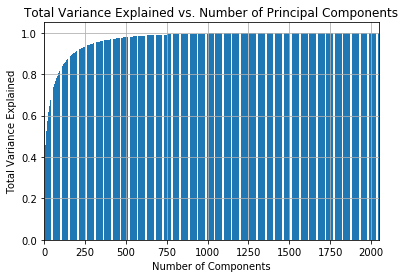

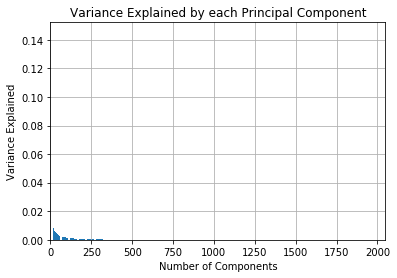

In [6]:
# Compute PCA for a large number of components
pca = PCA(n_components = 2048)
x_train_PCA = pca.fit_transform(HoG_feat.reshape(HoG_feat.shape[0],-1))
# Find the variances explained
marginal_variances = pca.explained_variance_ratio_

# Plot the total variance explained at for n components
total_variances = [sum(marginal_variances[:i]) for i in range(1,len(marginal_variances)+1)]
plt.title("Total Variance Explained vs. Number of Principal Components")
plt.xlabel("Number of Components"), plt.ylabel("Total Variance Explained")
plt.bar(range(1, len(total_variances) + 1), total_variances)
plt.ylim(ymin=0), plt.xlim(xmin=0, xmax=2048)
plt.grid(True)
plt.show()

# Plot the varaince explained by each component
plt.title("Variance Explained by each Principal Component")
plt.xlabel("Number of Components"), plt.ylabel("Variance Explained")
plt.bar(range(1, len(marginal_variances) + 1), marginal_variances)
plt.ylim(ymin=0), plt.xlim(xmin=0, xmax=2048)
plt.grid(True)
plt.show()

In [8]:
print(next(x[0] for x in enumerate(total_variances) if x[1] > 0.98))

# Use the number of components representing 99.9% of the data
nb_components = next(x[0] for x in enumerate(total_variances) if x[1] > 0.98)
pca = PCA(n_components = nb_components)
# Prepare training data
X_train_PCA = pca.fit_transform(HoG_feat.reshape(HoG_feat.shape[0],-1))
# Prepare test data
HoG_feat_test = compute_HoG(X_test, c_size, b_size, bins, height, width)
HoG_feat_test = np.array(HoG_feat_test)
X_test_PCA = pca.transform(HoG_feat_test.reshape(HoG_feat_test.shape[0],-1))

521


## Fit SVM and Predict

In [9]:
# We have chosen the LinearSVC() model from sklearn as our SVM
# Fit the model
then = time.clock()
svc_clf = LinearSVC()
svc_clf.fit(X_train_PCA,y_train)
now = time.clock()
print(now - then)

97.54067231775393


In [10]:
# Predict the classes
then = time.clock()
svc_pred = svc_clf.predict(X_test_PCA)
now = time.clock()
print(now - then)
print(classification_report(y_test,svc_pred))

0.03138838148905165
                       precision    recall  f1-score   support

    articulated_truck       0.63      0.57      0.60      1466
           background       0.85      0.96      0.90      7663
              bicycle       0.74      0.48      0.58       341
                  bus       0.68      0.74      0.71      1488
                  car       0.69      0.77      0.73      1470
           motorcycle       0.65      0.39      0.49       299
non_motorized_vehicle       0.62      0.10      0.17       248
           pedestrian       0.64      0.53      0.58       896
         pickup_truck       0.65      0.69      0.67      1465
    single_unit_truck       0.55      0.21      0.31       769
             work_van       0.62      0.54      0.57      1457

          avg / total       0.73      0.75      0.73     17562



## Fit Logistic Regression model and predict

In [11]:
then = time.clock()
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
lr_clf.fit(X_train_PCA,y_train)
now = time.clock()
print(now - then)

43.47233823398754


In [12]:
then = time.clock()
lr_pred = lr_clf.predict(X_test_PCA)
now = time.clock()
print(now - then)
print(classification_report(y_test,lr_pred))

0.031687751577038625
                       precision    recall  f1-score   support

    articulated_truck       0.63      0.61      0.62      1466
           background       0.88      0.95      0.91      7663
              bicycle       0.72      0.51      0.60       341
                  bus       0.70      0.74      0.72      1488
                  car       0.71      0.75      0.73      1470
           motorcycle       0.60      0.45      0.51       299
non_motorized_vehicle       0.48      0.18      0.26       248
           pedestrian       0.68      0.59      0.63       896
         pickup_truck       0.67      0.71      0.69      1465
    single_unit_truck       0.48      0.28      0.35       769
             work_van       0.60      0.60      0.60      1457

          avg / total       0.75      0.76      0.75     17562



## Fit KNN and predict

In [13]:
then = time.clock()
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train_PCA,y_train)
now = time.clock()
print(now - then)

4.999448544636692


In [14]:
then = time.clock()
knn_pred = knn_clf.predict(X_test_PCA)
now = time.clock()
print(now - then)
print(classification_report(y_test,knn_pred))

196.3690769372091
                       precision    recall  f1-score   support

    articulated_truck       0.77      0.87      0.82      1466
           background       0.90      0.96      0.93      7663
              bicycle       0.90      0.63      0.74       341
                  bus       0.81      0.95      0.87      1488
                  car       0.87      0.94      0.90      1470
           motorcycle       0.94      0.69      0.79       299
non_motorized_vehicle       0.85      0.40      0.55       248
           pedestrian       0.95      0.45      0.61       896
         pickup_truck       0.86      0.89      0.87      1465
    single_unit_truck       0.79      0.56      0.66       769
             work_van       0.89      0.82      0.85      1457

          avg / total       0.87      0.87      0.86     17562



# 2.1 Classifier Evaluation

In [15]:
# Adapted from sklearn Confusion Matrix tutorial
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (12,12))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## LinearSVC

In [16]:
# Perform k-fold cross validation
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='macro'),
           'recall' : make_scorer(recall_score, average='macro')}
svc_results = cross_validate(svc_clf, X_train_PCA, y_train, cv=10, verbose=100, scoring = scoring)
print(svc_results)

[CV]  ................................................................
[CV]  , accuracy=0.7440249045993171, precision=0.634018171908724, recall=0.5442875106840064, total= 1.4min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
[CV]  ................................................................
[CV]  , accuracy=0.7389776036958924, precision=0.6573138638131311, recall=0.5389196936265587, total= 1.4min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s
[CV]  ................................................................
[CV]  , accuracy=0.7428427925665495, precision=0.6679289882839644, recall=0.5464969009390988, total= 1.4min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.3min remaining:    0.0s
[CV]  ................................................................
[CV]  , accuracy=0.7320136655948553, precision=0.6586647375640061, recall=0.5312673814626456, total= 1.4min
[Parallel(n_jobs=1)]: Done   4 out of   4 | e

In [17]:
lr_results = cross_validate(lr_clf, X_train_PCA, y_train, cv=10, verbose=100, scoring = scoring)
print(lr_results)

[CV]  ................................................................
[CV]  , accuracy=0.756376782486443, precision=0.6561792472827587, recall=0.582466623089155, total=  40.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.8s remaining:    0.0s
[CV]  ................................................................
[CV]  , accuracy=0.7478156071105755, precision=0.6459811847870415, recall=0.5675827615595591, total=  38.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[CV]  ................................................................
[CV]  , accuracy=0.7533902561526871, precision=0.657513135686222, recall=0.5767000896549204, total=  41.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min remaining:    0.0s
[CV]  ................................................................
[CV]  , accuracy=0.7446744372990354, precision=0.6599076846368422, recall=0.5678159327329495, total=  40.3s
[Parallel(n_jobs=1)]: Done   4 out of   4 | ela

Normalized confusion matrix


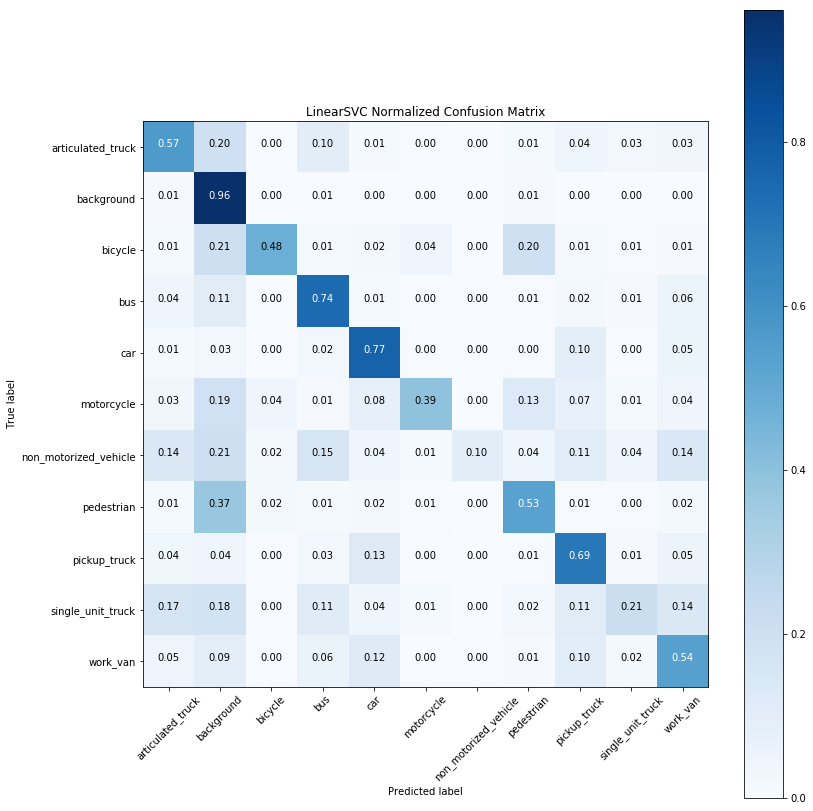

In [37]:
label = ['articulated_truck'] + ['background'] + ['bicycle'] + \
    ['bus'] + ['car'] + ['motorcycle'] + ['non_motorized_vehicle']\
    + ['pedestrian'] + ['pickup_truck'] + ['single_unit_truck'] + \
    ['work_van']

# Compute confusion matrix
svc_cnf_matrix = confusion_matrix(y_test, svc_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(svc_cnf_matrix, classes = label, normalize=True,
                      title='LinearSVC Normalized Confusion Matrix')


## Logistic Regression

Normalized confusion matrix


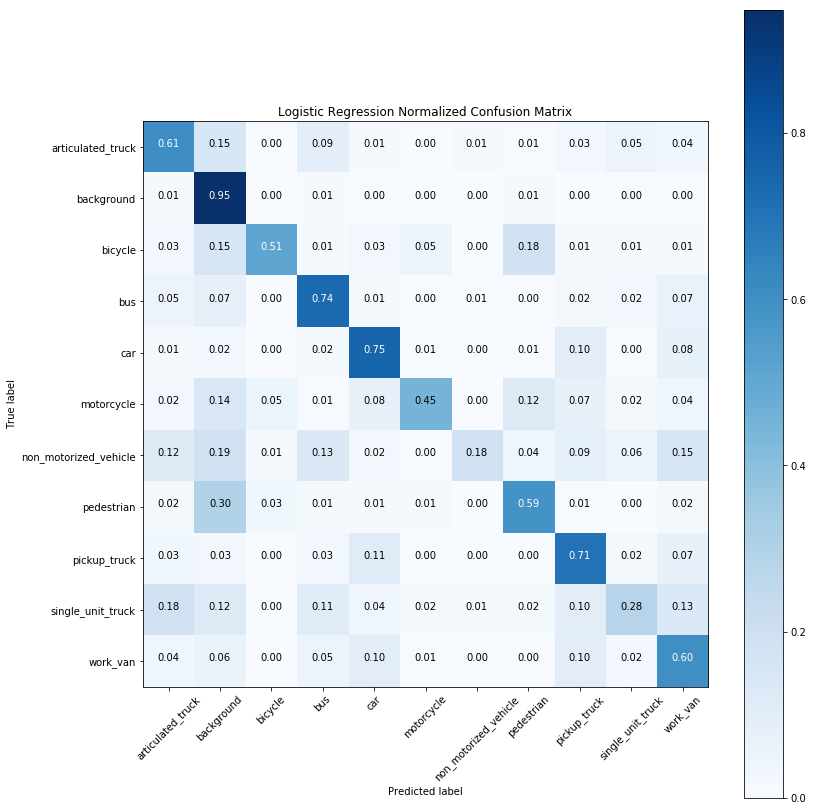

In [38]:
# Compute confusion matrix
lr_cnf_matrix = confusion_matrix(y_test, lr_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(lr_cnf_matrix, classes = label, normalize=True,
                      title='Logistic Regression Normalized Confusion Matrix')

plt.show()

## K Nearest Neighbors

Normalized confusion matrix


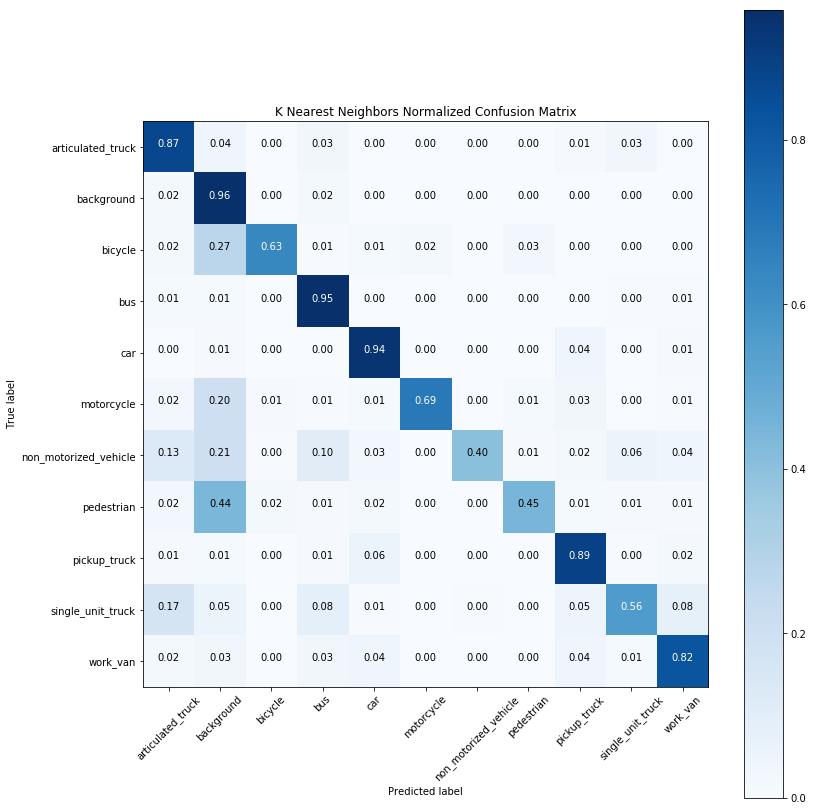

In [39]:
# Compute confusion matrix
knn_cnf_matrix = confusion_matrix(y_test, knn_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(knn_cnf_matrix, classes = label, normalize=True,
                      title='K Nearest Neighbors Normalized Confusion Matrix')

plt.show()